## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# select plot style
plt.style.use('fivethirtyeight')


## Generator
The Generator yields<br>
a sequence<br>
a query and<br>
a label<br>

The label indicates which element is more common in the sequence<br>
[ [ 1 ] [ 0 ] ] first more common<br>
[ [ 0 ] [ 1 ] ] first more common<br>
[ [ 1 ] [ 1 ] ] equally common<br>



In [2]:
def calc_label(seq, query):
    n1 = tf.reduce_sum(tf.cast(tf.equal(seq, query[0]), tf.int32)) # count frequency of first element
    n2 = tf.reduce_sum(tf.cast(tf.equal(seq, query[1]), tf.int32)) # count frequency of second element 
    
    return tf.constant([int(n1>=n2), int(n2>=n1)])

In [3]:
seq_len = 10

# a generator that yields sequences of length seq_len
# and queries
def sequence_and_query():
  while True:
      seq = tf.random.uniform(shape=(seq_len, 1), minval=0, maxval=10, dtype=tf.int32)
      query = tf.random.uniform(shape=(2,1), minval=0, maxval=10, dtype=tf.int32)
      label = calc_label(seq, query)
      yield seq, query, label


## Dataset

In [4]:
dataset_gen = tf.data.Dataset.from_generator(sequence_and_query,
                                             output_signature=(
                                              tf.TensorSpec(shape=(10,1), dtype=tf.int32),
                                              tf.TensorSpec(shape=(2,1), dtype=tf.int32),
                                              tf.TensorSpec(shape=(2), dtype=tf.int32)))


# We can take a fixed amount of datapoints from our generator dataset
num = 150
data_train_num = num * 64
data_test_num = num//10 * 64

train_dataset = dataset_gen.take(data_train_num).cache()
test_dataset = dataset_gen.take(data_test_num).cache()


## Inspect data

we can access <br> the sequence with elem[0]<br> the query with elem[1] and
<br> the label with elem[2]
<nr>for elem in dataset

In [5]:
for elem in train_dataset.take(1):
  print("Sequence:", "\n", elem[0], "\n")
  print("Query:", "\n", elem[1], "\n")
  print("Label:", "\n", elem[2])
  

Sequence: 
 tf.Tensor(
[[0]
 [1]
 [5]
 [8]
 [7]
 [7]
 [5]
 [4]
 [5]
 [7]], shape=(10, 1), dtype=int32) 

Query: 
 tf.Tensor(
[[3]
 [1]], shape=(2, 1), dtype=int32) 

Label: 
 tf.Tensor([0 1], shape=(2,), dtype=int32)


## Data pipeline

In [6]:
# create minibatches
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# encode data one-hot
train_dataset = train_dataset.map(lambda seq, query, label: 
                                                (tf.one_hot(seq, 10), tf.one_hot(query, 10), label), 
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

test_dataset = test_dataset.map(lambda seq, query, label: 
                                                (tf.one_hot(seq, 10), tf.one_hot(query, 10), label), 
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

# Prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# The Network

## LSTM Cell

Before we build the cell we should talk about input shapes and unit counts

The **gates**, **cell state** and **hidden state** are multiplied pointwise which each other at some point, so they need to have the same length or unit count.<br>
we will denote this with ***unit_num***

The problem is that the gates get a concatenated input which means that their output will not be able to be multiplied pointwise with for example the cell state (shape error (batch_size, **6**, 1, 10) != (batch_size, ****3, 1, 10)

So what we do, is set the units of the gates to **unit_num/2** and then reshape<br> the output (batch_size, 6, 1, 5) to (batch_size, 3, 1, 10) so that we match the cell state shape

The **input of the gates** (and also the **candidate layer**) consists of the concatination of a hidden state and the current input<br>
so we have an input shape of ***unit_num + 3 • 10***, because the current input consists of one sequence element and two query numbers which are all one-hot(10)  encoded









In [7]:
class LSTM_Cell(Model): 
    
    def __init__(self, unit_num = 10):
        super(LSTM_Cell, self).__init__()
        
        # Our LSTM_Cell needs the following things

        # Cell state
        self.cell_state = tf.zeros(shape = (batch_size,3,1,unit_num), dtype = tf.int32)

        # Hidden state
        self.hidden_state = tf.zeros(shape = (batch_size,3,1,unit_num), dtype = tf.int32)

        # A layer that proposes a new cell state candidate
        # based on the input and the hidden state
        self.candidate = tf.keras.layers.Dense(units=unit_num/2, 
                                               activation="tanh",
                                               #input_shape = (batch_size, unit_num + 30)
                                               )

        # The Gates
        # all gates (their outputs) will be multiplied pointwise 
        # with the cell state, so they need as much units as the cell state has elements

        # Forget Gate
        # f = σ(Wf[ht−1,xt]+bf)
        self.forget_gate = tf.keras.layers.Dense(units=unit_num/2, 
                                                 activation="sigmoid",
                                                 #input_shape = (batch_size, unit_num + 30)
                                                 )
        
        # Input Gate
        # i = σ(Wi[ht−1,xt]+bi)
        self.input_gate = tf.keras.layers.Dense(units=unit_num/2, 
                                                 activation="sigmoid",
                                                 #input_shape = (batch_size, unit_num + 30)
                                                 )
        
        # Output Gate
        # o = σ(Wo[ht−1,xt]+b0)
        self.output_gate = tf.keras.layers.Dense(units=unit_num/2, 
                                                 activation="sigmoid",
                                                 #input_shape = (batch_size, unit_num + 30)
                                                 )
        

        self.reshape_layer = tf.keras.layers.Reshape(target_shape = (3,1,unit_num))
        
        

       
    # LSTM cells are called with
    # current input x of a single time step
    # so one sequence element and the query
    # and also with the hidden_state of the previous time step and the cell_state
    # which are both vectors
    def call(self, hidden_state, xt, cell_state):
     
        # first we concatenate the hidden state (ht-1) with the current input (xt)
        # as they form the vector (v) that our cell works with as a new input
        # [ht−1,xt] = v
        cell_input = tf.concat([tf.cast(hidden_state, dtype=tf.int32), tf.cast(xt, dtype=tf.int32)], axis = 1) # SHAPE PROBLEM
       

        # then we propose a new cell state, based on this combined input
        cell_state_candidate = self.reshape_layer(self.candidate(cell_input))

        # next we feed the cell input [ht−1,xt] through the different gates
        forget_gate_out = self.reshape_layer(self.forget_gate(cell_input))
        input_gate_out  = self.reshape_layer(self.input_gate(cell_input))
        output_gate_out = self.reshape_layer(self.output_gate(cell_input))

        # print("cell_input.shape: ", cell_input.shape)
        # print("cell_state_candidate.shape: ", cell_state_candidate.shape)
        # print("forget_gate_out.shape: ", forget_gate_out.shape)
        # print("input_gate_out.shape: ", input_gate_out.shape)
        # print("output_gate_out.shape: ", output_gate_out.shape)
       
        # with whatever came through the gates we update the cell state
        #print("cell_state.shape: ", cell_state.shape)
        self.cell_state =  tf.cast(forget_gate_out, dtype=tf.float32) *  tf.cast(self.cell_state, dtype=tf.float32) +  tf.cast(input_gate_out, dtype=tf.float32) *  tf.cast(cell_state_candidate, dtype=tf.float32)

        # the new cell state now determines together with the output gate
        # the new hidden state
        self.hidden_state = output_gate_out * self.cell_state

       
        # for the next time step we will need 
        # the previous hidden state and the previous cell state
        return self.hidden_state#, self.cell_state


In [8]:
class LSTM(Model): 
    
    def __init__(self, unit_num = 10):
        super(LSTM, self).__init__()

        # The first thing we need is a LSTM cell
        self.lstm_cell = LSTM_Cell(unit_num)

        # Once we pushed our sequence through the LSTM cell
        # we are presented a hidden state of shape unit_num
        # this hidden state needs to be pushed through an output layer
        # so that the network can model our labels which have a shape 2 
        self.output_layer = tf.keras.layers.Dense(units=2, 
                                                  activation="sigmoid",
                                                  #input_shape = (batch_size, 3, 1, unit_num)
                                                  )
        
        self.flatten_layer = tf.keras.layers.Flatten()
       
   
    # The Model is called with a sequence (shape seq_len) and a query (shape 2)
    def call(self, data):

        seq = data[0]
        query = data[1]

        # The length of the sequence determine for how many timesteps
        # we activate our LSTM cell
        # We iterate over the sequence length and 
        # select from all batch elements the respective number
        # For example the 2nd sequence element from all 64 batch elements (bach size  = 64)
        for i in range(seq.shape[-1]):
        
            # The sequence elements are concatinated with the query and
            # passed through the LSTM cell
            seq_i = seq[:,i,:]

            # The input xt (batch_size, 3, 1, 10) for the LSTM cell is the 
            # concatination of one sequence element and the query 
            xt = tf.concat((tf.expand_dims(seq_i, axis = 1), query), axis = 1)

            # The LSTM cell also need a hidden state and a cell state as input
            # for that we take current states of the cell which will 
            # act as the previous states during the call
            # we catch the hidden state for the final output
            hidden_out = self.lstm_cell(self.lstm_cell.hidden_state, xt, self.lstm_cell.cell_state)
      
        # Now that the sequence has passed through the LSTM cell we can 
        # push the last hidden state through the output layer
        # and return the output
        # and also flatten because right now the shape is 
        # (batch_size, 3, 1, 10) and we want (batch_size, 30)
        # so that the output can be (batch_size, 2)
        output = self.output_layer(self.flatten_layer(hidden_out))

        return output


## Test LSTM

In [9]:
lstm_model = LSTM(unit_num = 10)

for elem in train_dataset.take(1):
    test_data = elem

print("Output: ", lstm_model(test_data)[0])

Output:  tf.Tensor([0.5172229 0.5362473], shape=(2,), dtype=float32)


In [10]:
for elem in train_dataset:
  a = elem
  break

In [11]:
a[2][0]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>

## Define Training


In [15]:
def train_step(model, data, loss_function, optimizer):
    with tf.GradientTape() as tape:
        pred = model(data)
        label = tf.cast(data[2], dtype=tf.float32)
        loss = loss_function(pred, label)
        # if the distance between prediction and label is < 0.5 
        # for the respective query elements we say the prediction is correct
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.greater(pred,0.5), tf.equal(label,1.0)), dtype=tf.float32))
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

def test(model, test_data, loss_function, training = False):
    # Test over complete test data
    
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for data in test_data:
        pred = model(data)
        label = tf.cast(data[2], dtype=tf.float32)
        loss = loss_function(pred, label)
        accuracy =  tf.reduce_mean(tf.cast(tf.equal(tf.greater(pred,0.5), tf.equal(label,1.0)), dtype=tf.float32))
        test_loss_aggregator.append(np.mean(loss.numpy()))
        test_accuracy_aggregator.append(accuracy)
    
    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)
      
    return test_loss, test_accuracy

## Train model

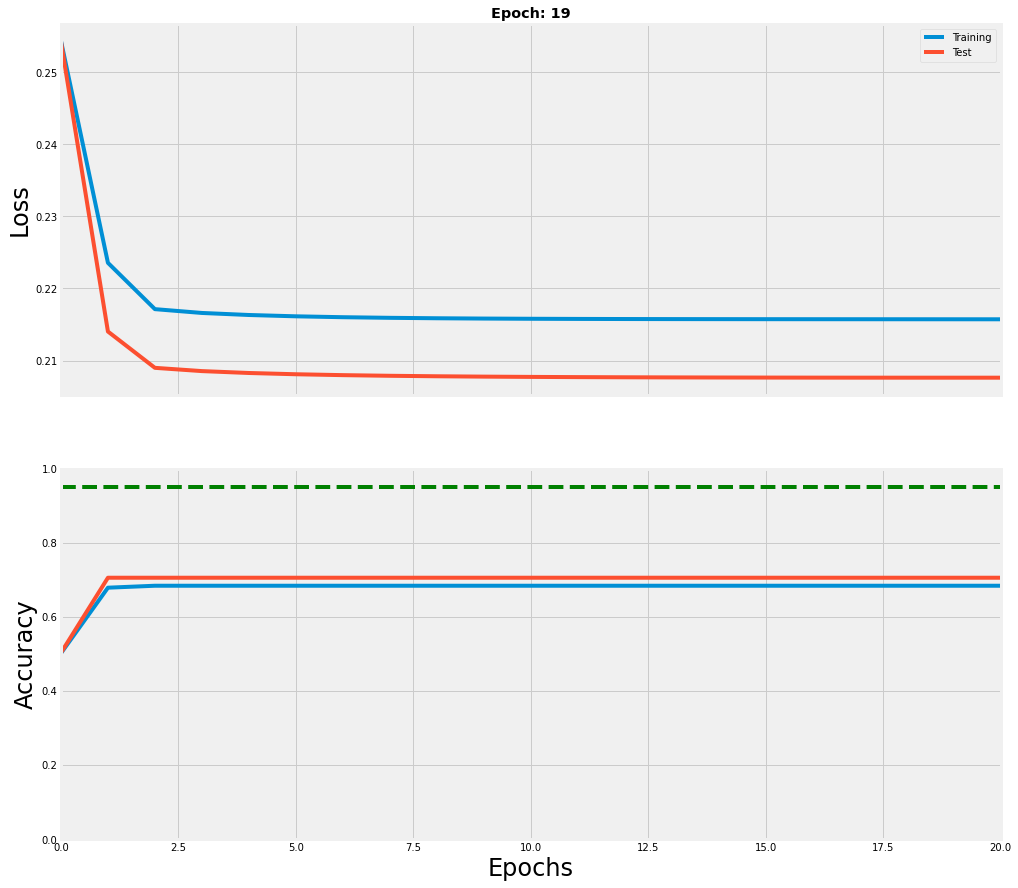

Train Accuracy:  0.6841272
Test loss:  [0.503125, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292, 0.7057292]
CPU times: user 4min 26s, sys: 9.96 s, total: 4min 36s
Wall time: 4min 29s


In [16]:
%%time
tf.keras.backend.clear_session()
from IPython.display import clear_output

### Hyperparameters
num_epochs = 20
learning_rate = 0.001
embedding_size = 10
running_average_factor = 0.95

model_lstm = LSTM(embedding_size)

# Initialize the loss
mean_squared_error = tf.keras.losses.MSE

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing model performance on train and test data before learning
train_loss, train_accuracy = test(model_lstm, train_dataset, mean_squared_error)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

test_loss, test_accuracy = test(model_lstm, test_dataset, mean_squared_error)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    # Training
    running_average_loss = 0
    running_average_accuracy = 0
    for data in train_dataset:
        train_loss, train_accuracy = train_step(model_lstm, data, mean_squared_error, optimizer)
        running_average_loss = np.mean((running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss).numpy())
        running_average_accuracy = np.mean((running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy).numpy())
        
    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)
   

    # Testing
    test_loss, test_accuracy = test(model_lstm, test_dataset, mean_squared_error)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    
    # Plotting
    clear_output(wait=True) 
    fontsize=24

    fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,15))

    ax[0].set_xlim((0,num_epochs))
    ax[0].plot(train_losses,label="Training")
    ax[0].plot(test_losses,label="Test")
    ax[0].set_ylabel("Loss",fontsize=fontsize)
    ax[0].set_title("Epoch: " + str(epoch), fontweight="bold")
    ax[0].legend()

    ax[1].plot(train_accuracies,label="Training")
    ax[1].plot(test_accuracies,label="Test")
    ax[1].set_ylabel("Accuracy",fontsize=fontsize)
    ax[1].set_xlabel("Epochs",fontsize=fontsize)
    ax[1].set_ylim([0, 1])
    ax[1].axhline(0.95,xmax=num_epochs,c='g',ls='--')

    # original_plot = fig.add_subplot(2,2,3)
    # original_plot.imshow(original.squeeze(), cmap = "inferno")
    # original_plot.set_title("Original (" + label + ")")
    # original_plot.axis("off")

    # reconstructed_plot = fig.add_subplot(2,2,4)
    # reconstructed_plot.imshow(reconstructed.squeeze(), cmap = "inferno")
    # reconstructed_plot.set_title("Reconstructed")
    # reconstructed_plot.axis("off")

    plt.show()

    print('Train Accuracy: ',running_average_accuracy)
    print('Test Accuracy: ',test_accuracy)